## Transfer Learning on Flowers Dataset

<a href="https://s3.amazonaws.com/fast-ai-imageclas/oxford-102-flowers.tgz">Download Dataset</a>&emsp;<a href="https://www.robots.ox.ac.uk/~vgg/publications/papers/nilsback08.pdf">Official Paper</a>&emsp;<a href="https://gist.github.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1">Download Labels</a>

#### Project Description
This project is 



### Table of Content:
* [Read the Data](#read-data)






### What I want to cover
* Image segmentation foreground 
* Find statistical models to use to show the variations | similarity detection
* 


## TO REDO
* Make class to store training/test/optim and criterion -> store results! 
* Add more description 
* Add jumping from one part to another
* Add table of content 
* Look at more description and state-of-the-art image processing 

In [1]:
# import essential packages
import os, cv2
import re

import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torchvision.models as models
from torch.nn import functional as F

from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from zipfile import ZipFile


# additional helper function to do behind the scene
import helper
import visualize

sns.set()
%matplotlib inline

### Read the data <a class="anchor" id="read-data">
The data provided by the fellowship-ai was presented in a huge folder with 8189 images along with text files containing training, test, and validation paths and their respective targets.    
![Folder Structure](images/structure.png)
Instead of finding the formatted folders online, I decided to take some time to deal with formatting manually. 
    
    In order to load the data in batches, we need to use ImageFolder and DataLoaders. The first is responsible for reading and transforming the images, whereas the last is for batch creation which is used in the training and test stages. To be able to use these functions, we need to have the following folder structure:
```
root/class_1/xxx.jpg
root/class_1/xxy.jpg
root/class_1/xxz.jpg

root/class_2/123.jpg
root/class_2/nsdf3.jpg
root/class_2/asd932_.jpg
```

#### Steps to take:
* Read the content of three sets (train, test, and validation)
* 

In [2]:
train_df = pd.read_csv('paths/train.txt', sep=' ', names=['path', 'idx'])
test_df = pd.read_csv('paths/test.txt', sep=' ', names=['path', 'idx'])
valid_df = pd.read_csv('paths/valid.txt', sep=' ', names=['path', 'idx'])

for df, name in [(train_df, 'train'), (test_df, 'test'), (valid_df, 'validation')]:
    print(f'{name} contains {df.shape[0]} images')

train contains 1020 images
test contains 6149 images
validation contains 1020 images


In [3]:
# unzip the jpg folder if it's not present 
# with ZipFile('jpg.zip', 'r') as f:
#     f.extractall()

In [4]:
if os.path.exists('jpg'):
    labels = scipy.io.loadmat('paths/imagelabels.mat')['labels'][0]
    dataset = os.listdir('jpg')
    df = pd.DataFrame({'path': dataset, 'target': labels})
    df.to_csv('paths/dataframe.csv', index=False)

else:
    df = pd.read_csv('paths/dataframe.csv')

classes = pd.read_csv('paths/class_names.txt', names=['target'])
classes.index += 1

label_dict, label_inverse = labels_dict = helper.prettify(classes)
next(iter(label_dict.items()))

(1, 'Pink Primrose')

In [5]:
# helper.create_folders(df)   ## uncomment if you need to create the folders

# transfer the images from "jpg" folder to their appropriate files 
# helper.transfer([train_df, test_df, valid_df], df)   ## uncomment to transfer images

### Success! 
Now the folders are in the format that I initially wanted to work with. They have the following format: <br>
![](images/right_folder.png)

However, there biggest issue is that PyCharm automatically sorts folders alphabetically. When I created the folders, I was using numbers to initialize them, thus the IDE did its intelligent thing to prettify the results by sorting them as <b>numbers</b>. When the DataLoader checks the structure, it reads them as <b>strings</b>. I had to manually create a holder which stores the DataLoader structure. It was done by writing this complex structure:<br>
<code>sorted([str(x) for x in df['target'].unique().astype('object').tolist()])</code><br>
Let's break it down:
1. Get the unique instances of target column (1-102);
2. Change the data type, so it is not a number anymore;
3. Turn pandas Series to list;
4. Convert each instances to string;
5. Sort alphabetically

As a result, we get the following <b>correct</b> structure: <br>
<code> 1, 10, 100, 101, 102, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 
    29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5, 50, 51, 
    52, 53, 54, 55, 56, 57, 58, 59, 6, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 7, 70, 71, 72, 73, 74, 75, 
    76, 77, 78, 79, 8, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 9, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99</code>


#### Trials 
At the very beginning, I wanted to create a string representation of folders with their actual names. However, doing so increased the complexity of finding the label's patterns in the visualization step. It was labeling sunflowers as roses, wallflowers as orange dahlia, and so on. I was sure there was a bug that I failed to look at. And after around 18-25 hours, thanks to <a href='https://github.com/pytorch/vision/issues/714'>this reply</a>, everything made sense! Here's the initial folder screenshot:
![](images/wrong_folders.png)

### Create the loaders
To not clutter the main page, this transformation happens in the helper function as well. 

In [6]:
# set the batch size
n_batches = 20

train_loader, test_loader, valid_loader = helper.create_loaders(n_batches)

### Visualize the data
Over here I want to visualize a whole batch of images

In [7]:
batch = iter(train_loader)

actual_order = sorted([str(x) for x in df['target'].unique().astype('object').tolist()])

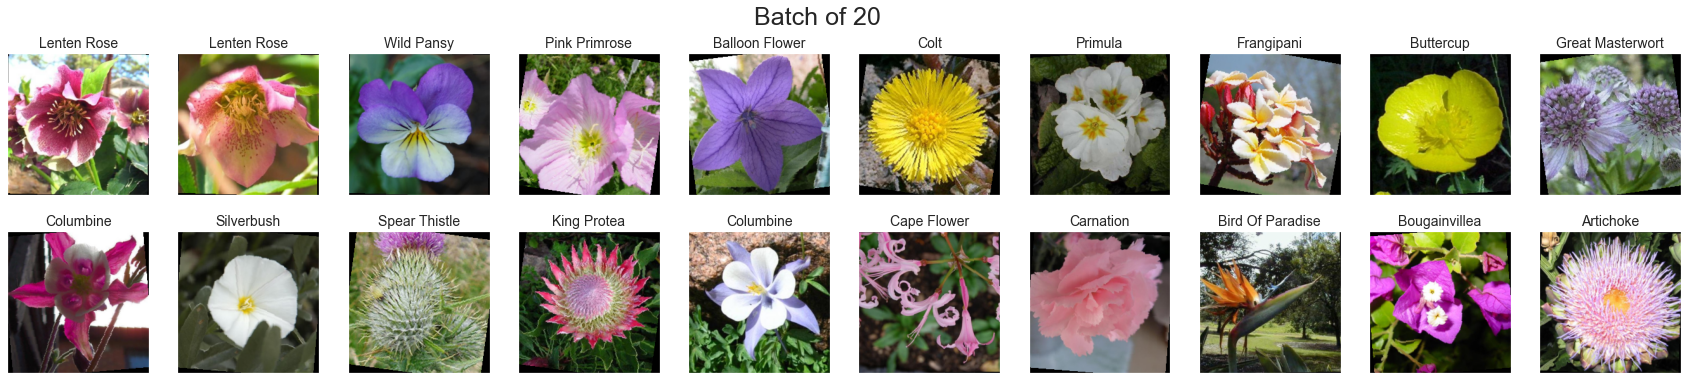

In [8]:
visualize.batch(batch, label_dict, n_batches, actual_order)

### Visualize the distribution of flowers
Since we already know that there are 1020 instances in the training set, I want to check the number of images in each class. The importance of doing so is to see if there's a class imbalance that needs to be taken care of. As we see, there's an equal distribution of the images, which is incredible! 

There are [10] images in each folder


AttributeError: 'FacetGrid' object has no attribute 'set_title'

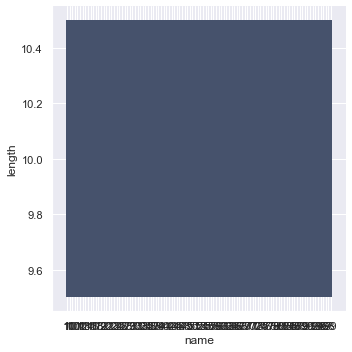

In [9]:
visualize.hist(targets=label_dict)

# Add statistical tests on image dist

# Add image segmentation & visualize 

### Time to train our model!


In [11]:
num_epochs = 30
criterion = nn.CrossEntropyLoss()

def get_optimizer(model):
    """
    """
    optimizer = optim.Adagrad(model.parameters(), lr=0.01)
    lr_decay = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)
    return optimizer, lr_decay


In [16]:
train_losses = []
valid_losses = []


def train(n_epochs:int, loaders:dict, model, optimizer, criterion, use_cuda:bool,
         save_path:str, learning_decay):
    """
    This function trains the model and shows the progress.

    Parameters:
        n_epochs (int): Number of epochs to train for
        loaders (dict): Dictionary of loaders to use
        model: Model being used
        optimizer: Selected optimizer
        criterion: Loss function
        use_cuda (bool): If GPU is enables or not
        save_path (str): Path to store the results in
        learning_decay_scheduler: Learning rate decay scheduler to use

    Returns:
        A trained model
    """
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            # record the average training loss, using something like
            optimizer.zero_grad()
            
            # get the final outputs
            output = model(data)
            
            # calculate the loss
            loss = criterion(output, target)
            
            # start back propagation
            loss.backward()
            
            # update the weights
            optimizer.step()
            
            train_loss += loss.item() * data.size(0)

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## update average validation loss 
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)
        
        train_loss /= len(train_loader.sampler)
        valid_loss /= len(valid_loader.sampler)
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        # print training/validation statistics every 5 epochs
        if epoch % 5 == 0:
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                epoch, 
                train_loss,
                valid_loss
                ))

        ## if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

        # update learning rate decay
        learning_decay.step()
            
    return model

In [33]:
def test(loaders, model, criterion, use_cuda):
    """
    This functions calculates the correctness and shows the results of the architecture.

    Parameters:
        loaders: Dictionary that stores all three loaders
        model: Model used for implementation
        criterion: Loss function
        use_cuda: If GPU is available or not

    Returns:
        The accuracy of the model
    """
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # keep track of correctly classified classes
    class_correct = list(0. for _ in range(102))
    class_total = list(0. for _ in range(102))

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # calculate the loss
        loss = criterion(output, target)
        
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

        for i in range(20):
            label = target.data[i]
            class_correct[label] += np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy()[i].item()
            class_total[label] += 1

    # show the accuracy
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

    for i in range(102):
        if class_total[i] > 0:
            print(f'Test Accuracy of {label_dict[int(actual_order[i])]}: %{100*class_correct[i] / class_total[i]}'
                  f'({np.sum(class_correct[i])}/{np.sum(class_total[i])})')

In [12]:
model = models.resnet34(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
# transfer to CUDA if applicable
use_cuda = torch.cuda.is_available()

# change the out features
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 102)

if use_cuda:
    model = model.cuda()

loaders = {'train': train_loader, 'test': test_loader, 'valid': valid_loader}
optimizer, lr_decay = get_optimizer(model)

In [20]:
model = train(num_epochs, loaders, model, optimizer, criterion, use_cuda, 'resnet34.pt', lr_decay)


Validation loss decreased (inf --> 4.610779).  Saving model ...
Validation loss decreased (4.610779 --> 4.448485).  Saving model ...
Validation loss decreased (4.448485 --> 4.428408).  Saving model ...
Validation loss decreased (4.428408 --> 3.769590).  Saving model ...
Epoch: 5 	Training Loss: 3.775674 	Validation Loss: 3.939117
Validation loss decreased (3.769590 --> 3.552093).  Saving model ...
Validation loss decreased (3.552093 --> 3.307918).  Saving model ...
Validation loss decreased (3.307918 --> 3.123335).  Saving model ...
Epoch: 10 	Training Loss: 2.862704 	Validation Loss: 3.094968
Validation loss decreased (3.123335 --> 3.094968).  Saving model ...
Validation loss decreased (3.094968 --> 2.852732).  Saving model ...
Validation loss decreased (2.852732 --> 2.721962).  Saving model ...
Validation loss decreased (2.721962 --> 2.567313).  Saving model ...
Epoch: 15 	Training Loss: 2.038910 	Validation Loss: 2.536955
Validation loss decreased (2.567313 --> 2.536955).  Saving mo

In [34]:
# load the model that got the best validation accuracy
# model.load_state_dict(torch.load('resnet34.pt'))    ## GPU version

model.load_state_dict(torch.load('resnet34.pt', map_location=torch.device('cpu')))

# check the test results
test(loaders, model, criterion, use_cuda)

IndexError: index 9 is out of bounds for dimension 0 with size 9

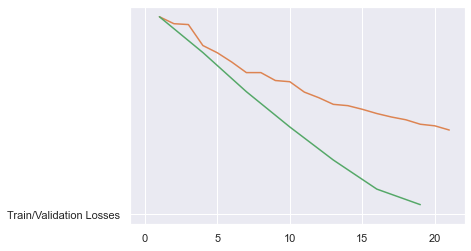

In [14]:
# test
valid_losses = [4.610779, 4.448485, 4.428408, 3.939117, 3.769590,
                3.552093, 3.307918, 3.307918, 3.123335, 3.094968,
                2.852732, 2.721962, 2.567313, 2.536955, 2.451873,
                2.353321, 2.272735, 2.207868, 2.103460, 2.066408,
                1.968210]

train_losses = [4.610779, 3.775674, 2.862704, 2.038910, 1.268716,
                0.590261, 0.227693]

plt.plot('Train/Validation Losses')
plt.plot(np.arange(1, len(valid_losses) + 1), valid_losses)
plt.plot(np.arange(1, len(valid_losses) + 1, step=3), train_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### Reference

